<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [19]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [20]:
newline='\n'
print(f'shape: {walmart.shape}')
print('----------')
print(f'Null data:{newline}{walmart.isnull().sum()}')
print('----------')
print(f'Dtypes:{newline}{walmart.dtypes}')
print('----------')
print(f'Unique Store: {walmart.Store.nunique()}')
print('----------')
print(f'Unique Dept: {walmart.Dept.nunique()}')

shape: (421570, 5)
----------
Null data:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
----------
Dtypes:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object
----------
Unique Store: 45
----------
Unique Dept: 81


**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [21]:
walmart['Date'] = pd.to_datetime(walmart.Date)

In [22]:
walmart.set_index('Date', inplace=True)

In [23]:
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [120]:
df = walmart[walmart['Store']==1].groupby(['Date']).sum()

In [122]:
df.drop(columns=['Store','Dept','IsHoliday'],inplace=True)

In [125]:
df.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

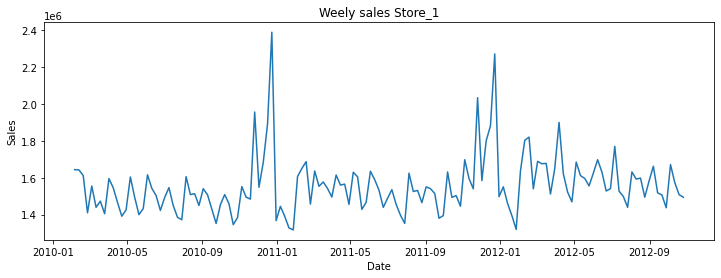

In [126]:
plt.figure(figsize=(12,4))
plt.title('Weely sales Store_1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(df);

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [104]:
df.index[100]

Timestamp('2012-01-06 00:00:00')

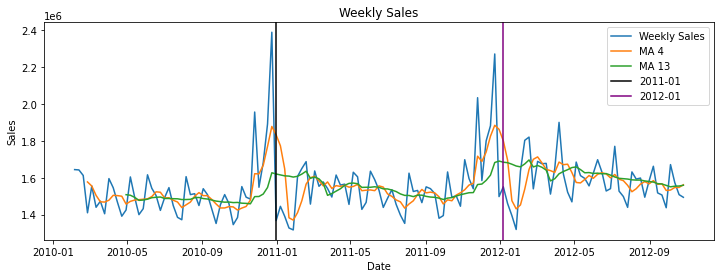

In [127]:
plt.figure(figsize=(12,4))
plt.plot(df, label='Weekly Sales')
plt.plot(df.rolling(4).mean(), label='MA 4')
plt.plot(df.rolling(13).mean(), label='MA 13')
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.axvline(x=df.index[47], color="black", label='2011-01')
plt.axvline(x=df.index[100], color="purple", label='2012-01')
plt.legend();

**Describe any trends that you notice**

In [107]:
# A: Seasonal spikes

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

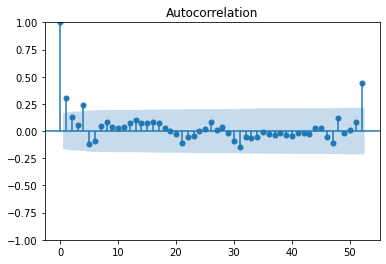

In [128]:
plot_acf(df, lags=52);

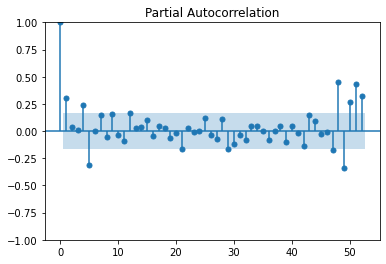

In [129]:
plot_pacf(df, lags=52);

In [112]:
# A: Scallop patterns can be seen in both ACF and PACF plot

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [130]:
y_train, y_test = train_test_split(df, shuffle=False)

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [138]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic',
                                             'p-value'])
    return dfoutput

In [139]:
interpret_dftest(adfuller(y_train))

Test Statistic   -4.688682
p-value           0.000088
dtype: float64

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [178]:
ar1 = ARIMA(endog=y_train,order=(1,0,0))
model1 = ar1.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [179]:
preds1 = model1.predict(start=df.index[107],end=df.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [180]:
print(f'MSE: {mean_squared_error(y_test,preds1)}')

MSE: 11108604490.663338


**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

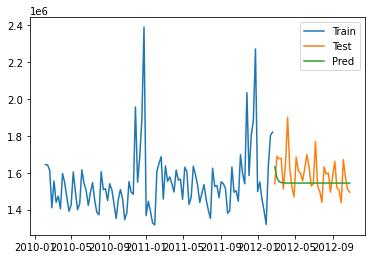

In [181]:
def plot_preds(preds):
    plt.plot(y_train,label='Train')
    plt.plot(y_test,label='Test')
    plt.plot(preds,label='Pred')
    plt.legend();
plot_preds(preds1)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- The first model poorly predict the sales data, since MSE score is so high.
- No MA(q) part to deal with spike

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [182]:
ar2 = ARIMA(endog=y_train,order=(2,0,2))
model2 = ar2.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [183]:
preds2 = model2.predict(start=df.index[107],end=df.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [184]:
print(f'MSE: {mean_squared_error(y_test,preds2)}')

MSE: 11047421610.653723


**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

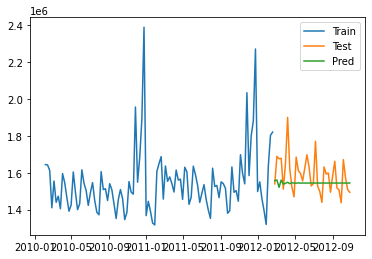

In [185]:
plot_preds(preds2)

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- not better than model 1

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [186]:
ar3 = ARIMA(endog=y_train,order=(2,1,2))
model3 = ar3.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [187]:
preds3 = model3.predict(start=df.index[107],end=df.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [188]:
print(f'MSE: {mean_squared_error(y_test,preds3)}')

MSE: 11863606618.19973


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

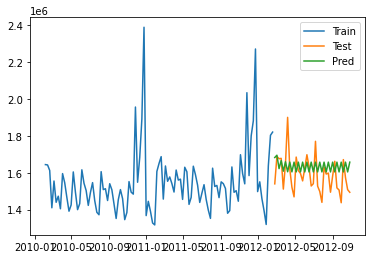

In [189]:
plot_preds(preds3)

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- 'Integrated' part of the model has been added (d: differenced to achieve stationarity)
- The third model start to form a wave of prediction

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [190]:
ar4 = ARIMA(endog=y_train,order=(52,0,1))
model4 = ar4.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [191]:
preds4 = model4.predict(start=df.index[107],end=df.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [192]:
print(f'MSE: {mean_squared_error(y_test,preds3)}')

MSE: 11863606618.19973


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

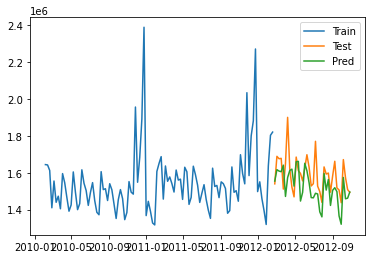

In [193]:
plot_preds(preds4)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- The last model of ARIMA is the best one so far
- AR(p) --> Autoregressive part has been optimized
- Hard regression activated

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [195]:
sarima = SARIMAX( endog=y_train,
                  order=(2,0,2),
                  seasonal_order=(1,1,1,52))
model = sarima.fit()
preds = model.predict(start=df.index[107],end=df.index[-1])

print(f'MSE: {mean_squared_error(y_test, preds)}')
print(f'RMSE {mean_squared_error(y_test, preds, squared=False)}')

MSE: 5442483784.059551
RMSE 73773.1914997552


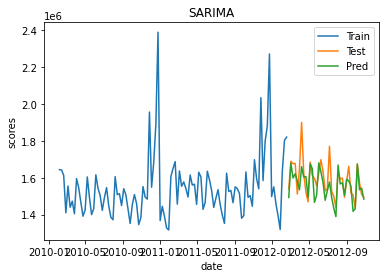

In [199]:
plot_preds(preds)
plt.xlabel('date')
plt.ylabel('scores')
plt.title('SARIMA');